In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-09-29 10:57:19--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.114
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  6.49MB/s    in 3.9s    

2019-09-29 10:57:23 (6.49 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-09-29 10:57:28--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.86
Connecting to fashion-mnist.s3-website.eu-central-1.amazo

In [2]:
!ls

sample_data		   train-images-idx3-ubyte.gz
t10k-images-idx3-ubyte.gz  train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte.gz


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
#Training PArams
learning_rate = 0.0002
batch_size = 32
epochs = 100000

#Network params
image_dimension = 784 #img sz is 28x28
neural_network_dimension = 128
latent_variable_dimension = 10 
z_noise_dim = 10 # must be same as latent var dim bcoz they are directly fed into the discriminator 

def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [0]:

# Weights and biases of Discriminator
Disc_W = {
    "disc_H" : tf.Variable(xavier_init([latent_variable_dimension, neural_network_dimension])), #W1
    "disc_final": tf.Variable(xavier_init([neural_network_dimension,1])) #W2
}

Disc_Bias= {
    "disc_H" : tf.Variable(xavier_init([neural_network_dimension])), #B1
    "disc_final": tf.Variable(xavier_init([1])) #B2
}

# Weight and Bias for Auto encoders
AE_weight = {"E_weight_encoder": tf.Variable(xavier_init([image_dimension, neural_network_dimension])), #W1
             "E_weight_hidden" : tf.Variable(xavier_init([neural_network_dimension, latent_variable_dimension])), #W2
             
             "D_weight_hidden" : tf.Variable(xavier_init([latent_variable_dimension, neural_network_dimension])), #Wdisc3
             "D_weight_decoder": tf.Variable(xavier_init([neural_network_dimension, image_dimension])) #W4
}

AE_bias = { "E_bias_encoder": tf.Variable(xavier_init([neural_network_dimension])), #B1
            "E_bias_hidden":  tf.Variable(xavier_init([latent_variable_dimension])), #B2
            "D_bias_hidden":  tf.Variable(xavier_init([neural_network_dimension])), #B3
            "D_bias_decoder":  tf.Variable(xavier_init([image_dimension])) #B1
}

In [0]:
#define placeholders for external input

z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dimension], name = "real_noise")


In [0]:
#creating computational graph
def Encoder(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, AE_weight["E_weight_encoder"]), AE_bias["E_bias_encoder"]))
  enc_output = tf.add(tf.matmul(hidden_layer, AE_weight["E_weight_hidden"]), AE_bias["E_bias_hidden"])
  return enc_output

def Decoder(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, AE_weight["D_weight_hidden"]), AE_bias["D_bias_hidden"]))
  dec_output = (tf.add(tf.matmul(hidden_layer, AE_weight["D_weight_decoder"]), AE_bias["D_bias_decoder"]))
  prob = tf.nn.sigmoid(dec_output)
  return prob, dec_output
  
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_W["disc_H"]), Disc_Bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, Disc_W["disc_final"]), Disc_Bias["disc_final"]))
  disc_output = tf.nn.sigmoid(final_layer)
  return disc_output
  

In [0]:
# building the AEN NW
latent_output = Encoder(x_input)
_, final_output = Decoder(latent_output)

 # Building the Disc NW
real_output_disc = Discriminator(z_input) #real data is coming from prior defined in form of noise
fake_output_disc = Discriminator(latent_output)  # Fake data "" latent variable generated by encoder

In [18]:
AE_Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = final_output, labels = x_input))

#GAN Loss
Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_disc)+tf.log(1.0-fake_output_disc))
Generator_Loss = -tf.reduce_mean(tf.log(fake_output_disc))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Define the variables

Encoder_var = [AE_weight["E_weight_encoder"], AE_bias["E_bias_encoder"], AE_weight["E_weight_hidden"], AE_bias["E_bias_hidden"]]
Decoder_var = [AE_weight["D_weight_decoder"], AE_bias["D_bias_decoder"], AE_weight["D_weight_hidden"], AE_bias["D_bias_hidden"]]
Discriminator_var = [Disc_W["disc_H"], Disc_W["disc_final"], Disc_Bias["disc_H"], Disc_Bias["disc_final"]]

#Define the optimizer
AutoEncoder_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(AE_Loss, var_list = Encoder_var + Decoder_var)
Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Discriminator_Loss, var_list = Discriminator_var)
Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Encoder_var)
  

In [24]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  x_batch, _ = mnist.train.next_batch(batch_size)
  
  #Generate noise to feed Discriminator
  z_noise = np.random.normal(0,1,[batch_size, z_noise_dim])
  _, AE_loss_epoch = sess.run([AutoEncoder_optimize, AE_Loss], feed_dict = {x_input:x_batch})

  _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:x_batch, z_input:z_noise})
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {x_input:x_batch})  
  
  #Running the Discriminator summary
  
  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))
  
  


Steps: 0: Generator Loss: 0.08944684267044067, Discriminator Loss:2.822495937347412
Steps: 2000: Generator Loss: 0.522484540939331, Discriminator Loss:1.6667721271514893
Steps: 4000: Generator Loss: 0.6321603059768677, Discriminator Loss:1.475841999053955
Steps: 6000: Generator Loss: 0.6137083768844604, Discriminator Loss:1.4712445735931396
Steps: 8000: Generator Loss: 0.6389098167419434, Discriminator Loss:1.4273643493652344
Steps: 10000: Generator Loss: 0.7201262712478638, Discriminator Loss:1.4319472312927246
Steps: 12000: Generator Loss: 0.690879225730896, Discriminator Loss:1.4424973726272583
Steps: 14000: Generator Loss: 0.6603438854217529, Discriminator Loss:1.4276323318481445
Steps: 16000: Generator Loss: 0.6527563333511353, Discriminator Loss:1.4316380023956299
Steps: 18000: Generator Loss: 0.6850460171699524, Discriminator Loss:1.4013385772705078
Steps: 20000: Generator Loss: 0.665576696395874, Discriminator Loss:1.4236721992492676
Steps: 22000: Generator Loss: 0.673789858818

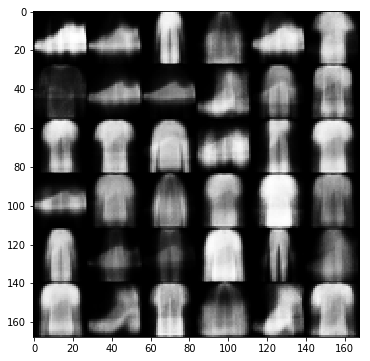

In [26]:
#Testing
# Generate images from noise, using the generator network
test_output, _ = Decoder(z_input)
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.normal(0,1,[batch_size, z_noise_dim])

  # Generate image from noise
  g = sess.run(test_output, feed_dict = {z_input:z_noise})
  # Reverse colors for better display
#   g=-1*(g-1)
  for j in range(n):
    #Draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()